# Observability starter for Azure OpenAI models

This accelerator aims to show how to easily enable observability in your <a href='https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models'>Azure OpenAI-based</a> Generative AI Solutions with LLMOps feature tools from DataRobot. This accelerator outlines an example of a byte-sized solution in its current state and then uses DataRobot tools to enable observability almost instantly for the solution.

DataRobot provides tools to enable the observability of external generative models. All the hallmarks of DataRobot MLOps are now available for LLMOps.

## Setup

### Install the prerequisite libraries

In [1]:
!pip install datarobotx[llm] datarobot-mlops datarobot-mlops-connected-client transformers "langchain==0.0.335"

In [2]:
!pip install openai==0.28

In [3]:
!pip install py-readability-metrics nltk

## Current state

Below is the current state of a simple GPT4-based text generation model implementation. The example uses the GPT4 model provided by Azure to generate text. The `get_completion` endpoint is used to generate text based on the input prompt. To enable observability on this implementation on your own, you would have to write code to take measurements, enable infrastructure to record all the measurements, and codify rules for interventions. This also introduces a lot of technical debt in the organization. 
<br>
<br>
<b>Note: The code illustrated here is also applicable to GPT 3.5 models. </b>

In [ ]:
import os

import openai

openai.api_type = os.environ["OPENAI_API_TYPE"]
openai.api_version = os.environ["OPENAI_API_VERSION"]
openai.api_base = os.environ["OPENAI_API_BASE"]
openai.api_key = os.environ["OPENAI_API_KEY"]

parameters = {"temperature": 0.2, "top_p": 0.8}

conversation = [{"role": "system", "content": "You are a helpful assistant."}]


def get_completion(user_input, conversation, **parameters):
    conversation.append({"role": "user", "content": user_input})
    response = openai.ChatCompletion.create(
        engine=os.environ["OPENAI_DEPLOYMENT_NAME"], messages=conversation, **parameters
    )
    return response


user_input = """explain agile scrum to me like I am a 5 year old"""
answer = get_completion(user_input, conversation, **parameters)

print(answer["choices"][0]["message"]["content"])

Sure, imagine you and your friends want to build a sandcastle. You all have different ideas about what the sandcastle should look like, how big it should be, and what features it should have. 
Agile Scrum is like a game plan to help you build the sandcastle together. 
First, you would choose a leader, let's call them the "Scrum Master". This person doesn't do the building but makes sure everyone knows what they're supposed to do and helps solve any problems.
Next, you all sit down and talk about what you want the sandcastle to look like and what parts it should have. You write all these things down on little cards - these are your "user stories". 
Then, you decide which parts of the sandcastle you're going to build first. You can't build everything at once, so you pick a few things that you think are the most important or the most fun. This is your "sprint backlog" and the time you spend building these parts is called a "sprint", which usually lasts a couple of weeks.
Every day, you ha

## Observability with DataRobot

To enable observability on the above GPT models from Azure, you first need to create a deployment in DataRobot. This can be done from the GUI or the API based on your preference.

### Connect to DataRobot

In [ ]:
# Initialize the DataRobot Client if you are not running this code outside DataRobot platform.
# import datarobot as dr
# dr.Client(<config>)

In [ ]:
from utilities import create_external_llm_deployment

deployment_id, model_id = create_external_llm_deployment(
    os.environ["OPENAI_DEPLOYMENT_NAME"] + " External"
)

[nltk_data] Downloading package punkt to /home/notebooks/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Initiate monitoring configuration

The cells below declare and initialize monitoring configuration. The monitoring configuration lets DataRobot understand how to interpret the inputs and outputs of the external model. Standard implementation of the hosted GPT4 model object has a create endpoint in the ChatCompletion object which expects prompt text, conversation history, and other parameters that are configured in the <a  href='https://drx.datarobot.com/reference/_autosummary/datarobotx.llm.MonitoringConfig.html#monitoringconfig'>MonitoringConfig</a> object as seen below. 

The <a href="https://drx.datarobot.com/reference/_autosummary/datarobotx.llm.MonitoringConfig.html#monitoringconfig">input_parser</a> object is helpful in capturing and storing the entire input or just the essential parts that you prefer.

In [ ]:
from datarobotx.llm.chains.guard import aguard, MonitoringConfig

monitor_config = MonitoringConfig(
    deployment_id=deployment_id,
    model_id=model_id,
    inputs_parser=lambda user_input, conversation, **parameters: {
        **{"user_input": user_input, "conversation": str(conversation)},
        **parameters,
    },
    output_parser=lambda x: {"answer": str(x["choices"][0]["message"].content)},
    target="answer",
)

In [ ]:
@aguard(monitor_config)
async def get_completion_cm(user_input, conversation, **parameters):
    conversation.append({"role": "user", "content": user_input})
    response = openai.ChatCompletion.create(
        engine=os.environ["OPENAI_DEPLOYMENT_NAME"], messages=conversation, **parameters
    )
    return response


conversation.append(answer["choices"][0].message.to_dict())
q2 = "Oh ok, how can I use agile in my life as a 5 year old?"
a2 = await get_completion_cm(q2, conversation, **parameters)

## Custom metrics
Observability with DataRobot also supports <a href='https://docs.datarobot.com/en/docs/mlops/deployment-settings/custom-metrics-settings.html'>custom user metrics</a>. The following cells show how users can start capturing toxicity in user prompts and readability in generative model responses. Add the custom metrics in the cell below that you want to record to your deployment. Again, this step can be done using the GUI or the API based on user preference. <br>
- Toxicity in the user prompt <br>
- Readability (Flesch Score) of the model response 

In [ ]:
from utilities import create_custom_metric

TOX_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Prompt Toxicity",
    baseline="0.1",
    type="average",
    directionality="lowerIsBetter",
)

READ_CUSTOM_METRIC_ID = create_custom_metric(
    deployment_id=deployment_id,
    name="Response Readability",
    baseline="30",
    type="average",
    directionality="higherIsBetter",
)

### Update the GPT completion endpoint

Modify the prediction function to add code that calculates the metrics and submits them to the deployment. Now, whenever the prediction is requested from the GPT model, the metrics are calculated and submitted on the deployment enabling you to monitor and intervene as necessary.

In [ ]:
from utilities import get_flesch_score, get_text_texicity, submit_custom_metric


@aguard(monitor_config)
async def get_completion_cm(user_input, conversation, **parameters):
    conversation.append({"role": "user", "content": user_input})
    response = openai.ChatCompletion.create(
        engine=os.environ["OPENAI_DEPLOYMENT_NAME"], messages=conversation, **parameters
    )
    try:
        submit_custom_metric(
            deployment_id,
            READ_CUSTOM_METRIC_ID,
            get_flesch_score(response["choices"][0]["message"]["content"]),
        )
        submit_custom_metric(
            deployment_id, TOX_CUSTOM_METRIC_ID, get_text_texicity(user_input)
        )
    except Exception as e:
        print(e)
        pass
    return response


conversation.append(a2["choices"][0].message.to_dict())
q3 = "Oh ok, Are there any alternatives to agile?"
await get_completion_cm(q3, conversation, **parameters)

<OpenAIObject chat.completion id=chatcmpl-7sn03BvrVpFhsZHRf5oZgl2yrkCbg at 0x7fb52c2e0860> JSON: {
  "id": "chatcmpl-7sn03BvrVpFhsZHRf5oZgl2yrkCbg",
  "object": "chat.completion",
  "created": 1693292423,
  "model": "gpt-4-32k",
  "choices": [
    {
      "index": 0,
      "finish_reason": "stop",
      "message": {
        "role": "assistant",
        "content": "Yes, there are several alternatives to Agile. Here are a few:\n\n1. **Waterfall**: This is a more traditional method where you plan everything in detail at the beginning and then follow the plan step by step. It's like planning to build an entire sandcastle before you start, and not changing the plan until you're done.\n\n2. **Kanban**: This is a method where you visualize your work on a board and limit how many tasks you're working on at the same time. It's like having a chart of your sandcastle with pictures of all the parts, and only working on a few parts at a time.\n\n3. **Lean**: This is a method that focuses on elimina

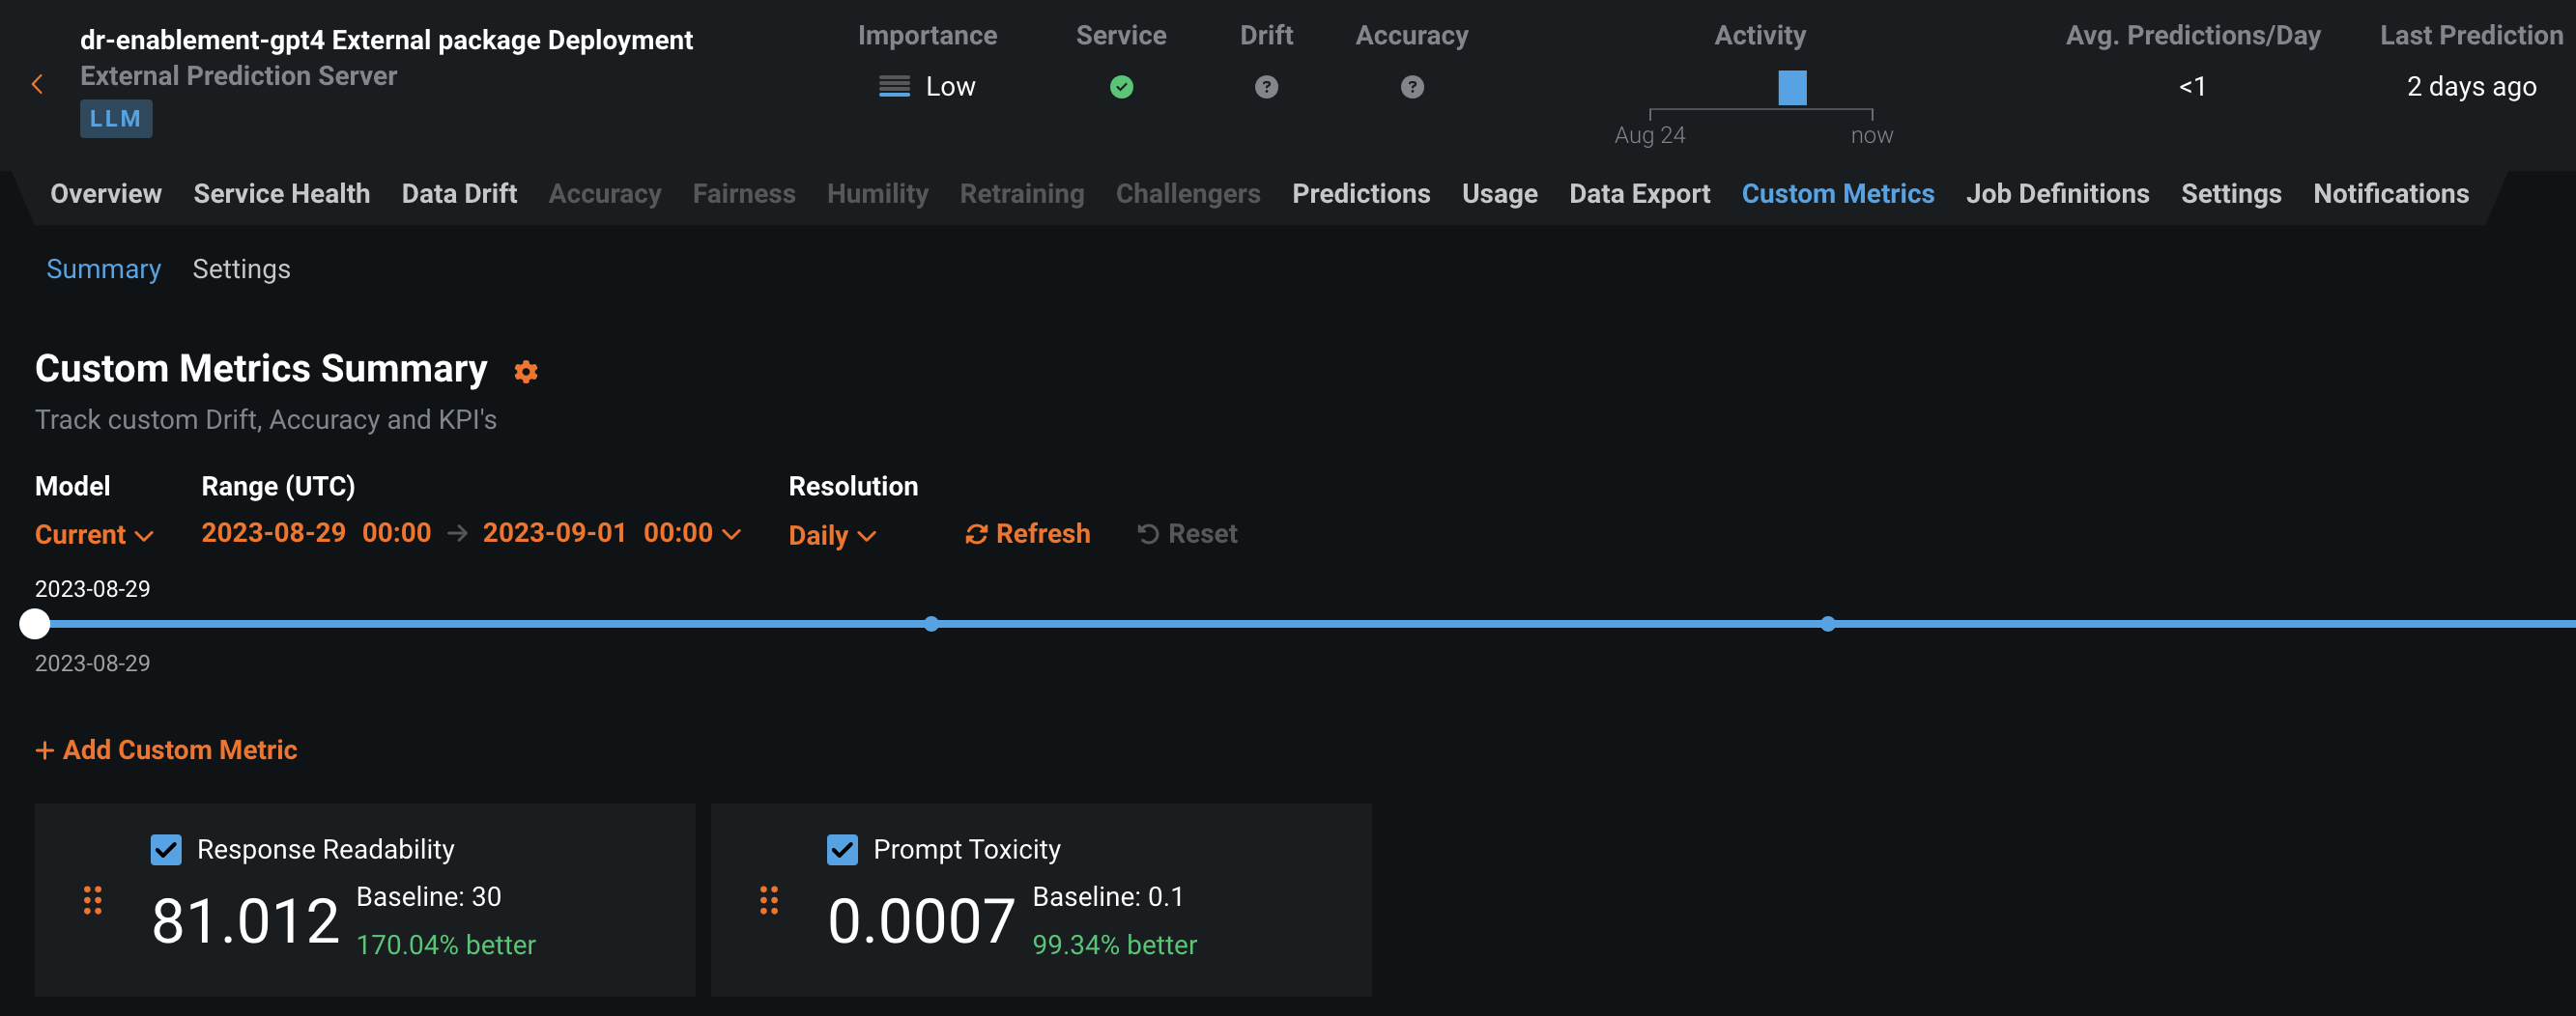

## Conclusion

Using DataRobot's tools for LLMOps, you can implement observability for Azure GPT-based applications easily with less friction while avoiding increased technical debt.